In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, LSTM, Dense

# Found out about this cool function from someone else's code:
# it automatically partitions a data set into training and validation data
from sklearn.model_selection import train_test_split

from toolbox import Preprocessing, VideoAnalysis, PredictionSample

import pickle

In [5]:
dataFiles = Preprocessing.listDataFiles(excludeDataWithoutMovies=True)

propertyFiles = Preprocessing.loadRunData(dataFiles)
videos = Preprocessing.loadVideo(dataFiles)
matFiles = Preprocessing.loadMatFile(dataFiles)

In [6]:
# Import the data
#fT = .3
sL = 10

fTPercentiles = np.linspace(.05, .60, 12)

fTValues = []
for i in range(len(matFiles)):
    fTValues.append(matFiles[i]["deltaF"])
    
fTValues = np.array([abs(val) for subList in fTValues for val in subList])
fTValues.sort()

fTArr = np.zeros(len(fTPercentiles))
for i in range(len(fTArr)):
    fTArr[i] = fTValues[int(len(fTValues)*fTPercentiles[i])]
    
scores = [VideoAnalysis.averageBrightness, VideoAnalysis.standardDeviation]

# inputs, outputs = [], []

# for i in range(len(fTArr)):
#     currInputs, currOutputs = PredictionSample.fullPredictionSample(videos, propertyFiles, matFiles, scores, sampleLength=sL, forceEventThreshhold=fTArr[i])
#     inputs.append(currInputs)
#     outputs.append(currOutputs)

In [7]:
trainingInput = []
validationInput = []
trainingOutput = []
validationOutput = []

for i in range(len(fTArr)):
    # Partition the data
    # 42 is just a random seed, and we'll take 10% of the data for validation
    currTrainingInput, currValidationInput, currTrainingOutput, currValidationOutput = train_test_split(inputs[i][:,1:,:], outputs[i], test_size=0.1, random_state=1)
    print(np.shape(currTrainingInput), np.shape(currValidationInput))
    #print(sum(trainingOutput)/len(trainingOutput))
    #print(sum(validationOutput)/len(validationOutput))
    trainingInput.append(currTrainingInput)
    validationInput.append(currValidationInput)
    trainingOutput.append(currTrainingOutput)
    validationOutput.append(currValidationOutput)

(2788, 2, 10) (310, 2, 10)
(2752, 2, 10) (306, 2, 10)
(2703, 2, 10) (301, 2, 10)
(2640, 2, 10) (294, 2, 10)
(2559, 2, 10) (285, 2, 10)
(2485, 2, 10) (277, 2, 10)
(2408, 2, 10) (268, 2, 10)
(2345, 2, 10) (261, 2, 10)
(2250, 2, 10) (250, 2, 10)
(2176, 2, 10) (242, 2, 10)
(2098, 2, 10) (234, 2, 10)
(1989, 2, 10) (221, 2, 10)


In [2]:
# with open('inputs', 'wb') as file:
#     pickle.dump(inputs, file)
    
# with open('outputs', 'wb') as file:
#     pickle.dump(outputs, file)

with open('inputs', 'rb') as file:
    inputs = pickle.load(file)
    
with open('outputs', 'rb') as file:
    outputs = pickle.load(file)

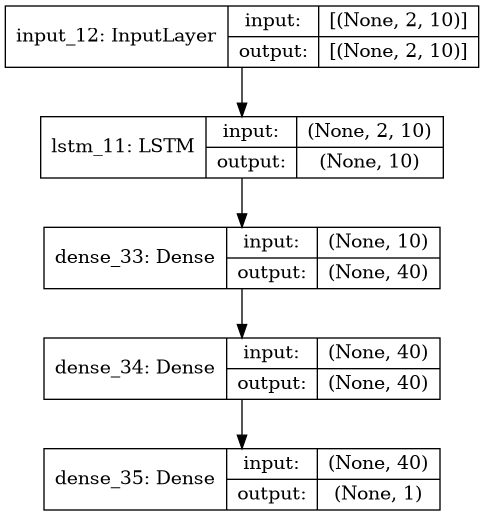

In [8]:
# Setup of the network
# Simple stacked network
models = []
for i in range(len(fTArr)):
    model = keras.Sequential()

    # Just three layers: an input, an LSTM, and the output, which should be either 1 or 0
    model.add(Input(shape=(len(scores), sL)))
    model.add(LSTM(sL, activation='tanh'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(40, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    models.append(model)
    
keras.utils.plot_model(model, show_shapes=True)

In [9]:
#batchsize = 50
numEpochs = 1000
#cost = []
accuracy = np.zeros(len(fTArr))

for i in range(len(fTArr)):
    models[i].fit(trainingInput[i], trainingOutput[i], epochs=numEpochs, verbose=0)
    accuracy[i] = models[i].evaluate(validationInput[i], validationOutput[i])[1]

plt.plot(fTPercentile, accuracy)
#for i in range(len(inputs)%batchsize):
#    cost.append(model.train_on_batch(inputs[i:min(i+batchsize,len(inputs)),1:,:], outputs[i:min(i+batchsize,len(inputs))])[0])
#plt.plot(cost)

7/7 [==============================] - 0s 807us/step - loss: 0.6896 - accuracy: 0.5339


NameError: name 'fTPercentile' is not defined

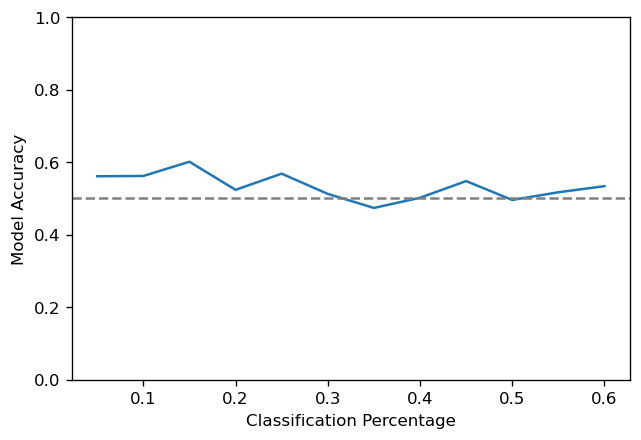

In [21]:
plt.plot(fTPercentiles, accuracy)
plt.axhline(.5, linestyle='--', c='gray')
plt.xlabel('Classification Percentage')
plt.ylabel('Model Accuracy')
plt.ylim([0, 1])
plt.savefig('images/TrainingTest_images/multi_accuracy.png')
plt.show()

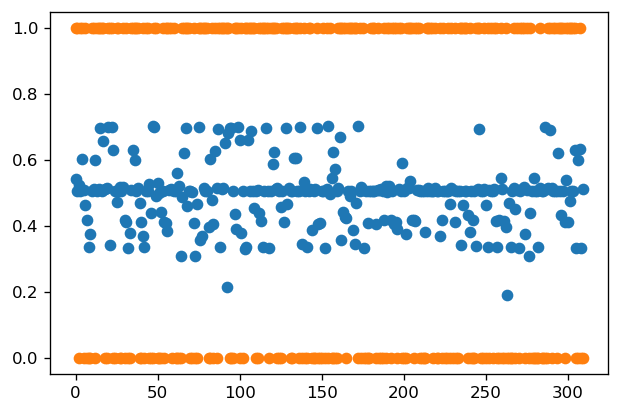

In [27]:
index = 0
predict = models[index].predict_on_batch(validationInput[index])
xArr = np.arange(len(predict))
plt.scatter(xArr, predict)
plt.scatter(xArr, validationOutput[index])
plt.show()
#print(np.array(list(zip(predict, validationOutput[index]))))